In [26]:
import pandas as pd
import numpy as np

class ConBacktester():
    ''' A backtester class for a simple Contrarian trading strategy
    '''

    def __init__(self,symbol,start,end,tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()


    def __repr__(self) -> str:
        return "ConBacktester | symbol={}, start={}, end={}, ptc={}".format(self.symbol,self.start,self.end,self.tc)
    
    def get_data(self):
        raw = pd.read_csv('intraday_pairs.csv',parse_dates=['time'],index_col='time')
        raw = raw[self.symbol].to_frame()
        raw.columns = ['Price']
        raw['Returns'] = np.log(raw.div(raw.shift()))
        raw
        self.data = raw
        return raw

    def test_strategy(self,window):
        ''' Backtests the simple contrarian trading strategy.
        
        Parameters
        ----------
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
        data = self.data.copy().dropna()
        # Determines what position we need to take depending on the direction of the return
        data["Position"] = -np.sign(data["Returns"].rolling(self.window).mean())
        ## Determines the corresponding return if we take the Position.
        data["Strategy"] = data["Position"].shift(1) * data["Returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["Trades"] = data.Position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.Strategy = data.Strategy - data.Trades * self.tc
        
        # Calculates the cumulative return of the BUY/HOLD strategy
        data["C_Returns"] = data["Returns"].cumsum().apply(np.exp)
        #Calculates the cumulative return of our strategy
        data["C_Strategy"] = data["Strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["C_Strategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["C_Returns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)

    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run .test_strategy() method first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["C_Returns", "C_Strategy"]].plot(title=title, figsize=(12, 8))

    def optimize_parameter(self,window_range):
        '''Determines the optimal window from range given, that produces the highest return
        '''
        windows = range(*window_range)
        results = []

        for window in windows:
            results.append(self.test_strategy(window)[0])

        best_perf = np.max(results) # best performance
        opt = windows[np.argmax(results)] # optimal parameter

        results_df = pd.DataFrame({'Window':windows,'Result':results})
        self.results_overview = results_df
    
        return best_perf, opt
    
    
        


In [27]:
tester = ConBacktester("EURUSD","2012-01-01","2020-12-31",0.0007)
tester

ConBacktester | symbol=EURUSD, start=2012-01-01, end=2020-12-31, ptc=0.0007

In [28]:
tester.test_strategy(3)

(0.508016, -0.420473)

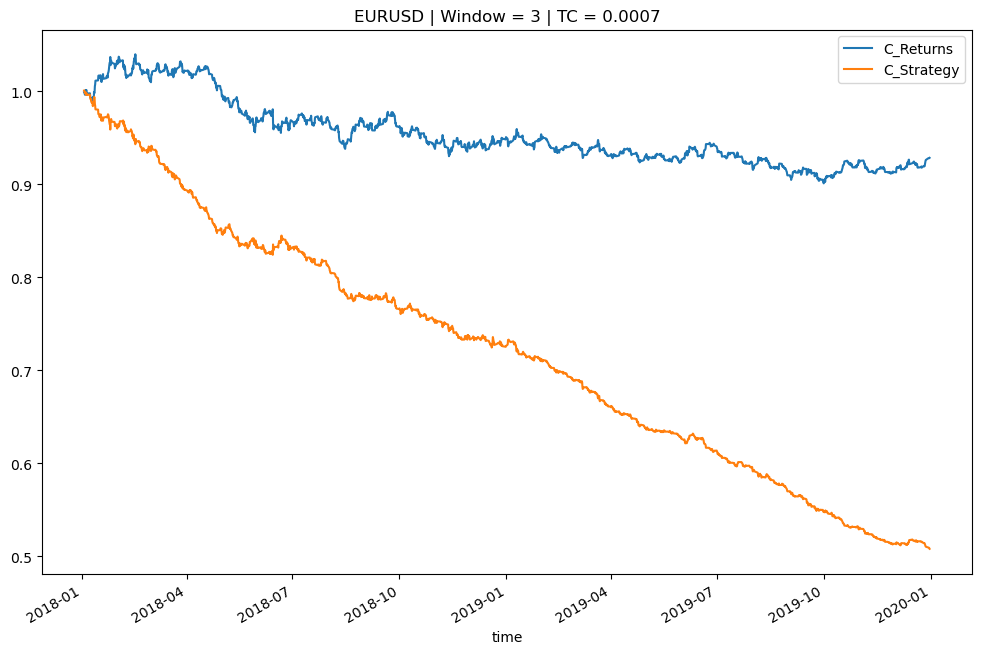

In [29]:
tester.plot_results()

In [30]:
tester.optimize_parameter((1,50))
# So, the overall return is 1.02766, with an optimal window of 44

(1.02766, 44)

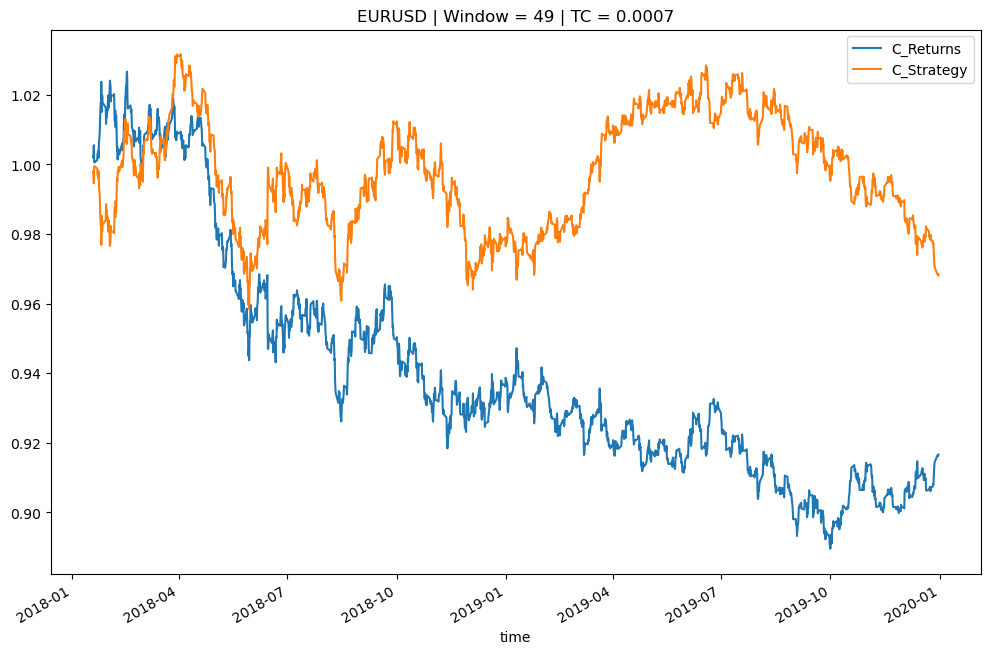

In [31]:
tester.plot_results()

In [32]:
tester.results

,Price,Returns,Position,Strategy,Trades,C_Returns,C_Strategy
time,,,,,,,
2018-01-18 10:00:00+00:00,1.223915,0.002028,-1.0,-0.002028,0.0,1.002030,0.997974
2018-01-18 16:00:00+00:00,1.223895,-0.000016,-1.0,0.000016,0.0,1.002014,0.997990
2018-01-18 22:00:00+00:00,1.226670,0.002265,-1.0,-0.002265,0.0,1.004286,0.995732
2018-01-19 04:00:00+00:00,1.228160,0.001214,-1.0,-0.001214,0.0,1.005506,0.994524
2018-01-19 10:00:00+00:00,1.222085,-0.004959,-1.0,0.004959,0.0,1.000532,0.999468
...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.0,0.916248,0.968475
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.0,0.916264,0.968458
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.0,0.916391,0.968324


In [37]:
tester.results_overview.nlargest(10,columns="Result")

,Window,Result
43,44,1.027660
46,47,1.004960
35,36,0.997132
44,45,0.992454
45,46,0.978699
42,43,0.977498
41,42,0.975342
48,49,0.968099
37,38,0.964531
39,40,0.964390


In [38]:
tester.results_overview.nsmallest(10,columns='Result')

,Window,Result
0,1,0.261361
1,2,0.391565
3,4,0.480317
2,3,0.508016
4,5,0.523877
5,6,0.569707
6,7,0.576817
7,8,0.624744
8,9,0.627675
9,10,0.652037
